# CNN実装
---

### モジュールの読み込み

In [1]:
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import CIFAR10, ImageFolder
from torchvision.utils import make_grid

# モデル構造の表示
from torchinfo import summary

# その他
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from tqdm import tqdm
from PIL import Image

### 計算デバイス

In [9]:
# GPUが利用できる場合はGPUを選択
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


## 1. データの準備
---

In [10]:
def load_cifar10(transform, train:bool):
    cifar10_dataset = CIFAR10(
                        root='./data',
                        train=train,
                        download=True,
                        transform=transform
                        )
    return cifar10_dataset

In [2]:
#データ拡張
train_transform = transforms.Compose([
                            # transforms.RandomHorizontalFlip(p=0.5),
                            # transforms.RandomVerticalFlip(p=0.5),
                            # transforms.RandomRotation(degrees=30),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0)
])

test_transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = load_cifar10(transform=test_transform, train=True)
test_dataset = load_cifar10(transform=test_transform, train=False)

# データ数とデータ形状を確認
print(f'data size : {len(dataset)}')
print(f'data shape : {dataset[0][0].shape}')

# 学習用(Train)と検証用(Validation)への分割数を決める
valid_ratio = 0.1                               # 検証用データの割合を指定
valid_size = int(len(dataset) * valid_ratio)    # 検証用データの数
train_size = len(dataset) - valid_size          # 学習用データ = 全体 - 検証用データ
print(f'train samples : {train_size}')
print(f'valid samples : {valid_size}')

# 読み込んだデータをランダムに選んで分割
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
train_dataset.dataset.transform = train_transform

# データローダーを作成
train_loader = DataLoader(
    train_dataset,          # データセットを指定
    batch_size=256,          # バッチサイズを指定
    shuffle=True,           # シャッフルの有無を指定
    drop_last=True,         # バッチサイズで割り切れないデータの使用の有無を指定
    pin_memory=True,        # 少しだけ高速化が期待できるおまじない
    num_workers=2           # DataLoaderのプロセス数を指定
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=256,
    shuffle=False,
    pin_memory=True,
    num_workers=2    
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

NameError: name 'load_cifar10' is not defined

In [3]:
def sample_show(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=0, drop_last=False)
    sample_cifar10, _ = next(iter(loader))
    grid = make_grid(sample_cifar10, nrow=16, padding=1, normalize=True)
    plt.figure(figsize=(12.8, 5.6))
    plt.imshow(grid.numpy().transpose(1,2,0))
    plt.show()

In [4]:
sample_show(train_dataset)
sample_show(valid_dataset)
sample_show(test_dataset)

NameError: name 'train_dataset' is not defined

## 2. モデル構築
---

### カスタムレイヤー

In [7]:
# Convolution層、BatchNormalization層(option)、ReLU層をまとめたブロック
# ブロックを作成することで、モデル定義のコードが煩雑になることを防ぐ
class EncoderBlock(nn.Module):
    def __init__(self, in_feature, out_future, use_bn=True):
        super().__init__()
        self.use_bn = use_bn

        self.in_feature = in_feature
        self.out_feature = out_future

        # BatchNormalizationを使用する場合、バイアス項は無くても良い
        # 標準化の際にバイアスもまとめて処理されるため
        self.conv = nn.Conv2d(in_feature, out_future, kernel_size=3, stride=1, padding=1, bias=not use_bn)
        self.bn = nn.BatchNorm2d(out_future)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out) if self.use_bn else x  # bn層を使わない場合はxを代入
        out = self.relu(out)
        return out

### モデル定義

In [8]:
class Classifier(nn.Module):
    def __init__(self, class_num, enc_dim, in_w, in_h):
        super().__init__()

        # self.enc_dim = enc_dim
        self.in_w = in_w
        self.in_h = in_h
        self.fc_dim = enc_dim*4 * int(in_h/2/2/2) * int(in_w/2/2/2) #pooling回数分割る
        self.class_num = class_num

        self.encoder = nn.Sequential(
            EncoderBlock(3      , enc_dim),
            EncoderBlock(enc_dim, enc_dim),
            nn.MaxPool2d(kernel_size=2),#h,wが1/2

            EncoderBlock(enc_dim  , enc_dim*2),
            EncoderBlock(enc_dim*2, enc_dim*2),
            nn.MaxPool2d(kernel_size=2),

            EncoderBlock(enc_dim*2, enc_dim*4),
            EncoderBlock(enc_dim*4, enc_dim*4),
            nn.MaxPool2d(kernel_size=2),
        )


        self.fc = nn.Sequential(
            nn.Linear(self.fc_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, self.class_num),
        )
    
    def forward(self, x):
        out = self.encoder(x)
        out = out.view(-1, self.fc_dim)

        out = self.fc(out)

        return out

### 重みの初期化
Pytorchは何も指定しない場合、一様分布を用いて重みの初期化を行うが、勾配消失を起こしにくい初期化方法が提案されている。  
 - kaimingの初期化(Heの初期化)：ReLU関数に有効
 - Xavierの初期化(Glorotの初期化)：Sigmoid関数に有効  

In [9]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d): # Convolution層が引数に渡された場合
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu') # kaimingの初期化
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)   # bias項は0に初期化
    elif isinstance(m, nn.BatchNorm2d):         # BatchNormalization層が引数に渡された場合
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):              # 全結合層が引数に渡された場合
        nn.init.kaiming_normal_(m.weight.data)  # kaimingの初期化
        nn.init.constant_(m.bias.data, 0)       # biasは0に初期化

### モデルの構築と確認

In [10]:
# モデルの構築
model = Classifier(class_num=10, enc_dim=128, in_w=32, in_h=32)

# 計算に使用するデバイスへモデルを転送
model.to(device)

# 重みの初期化
model.apply(initialize_weights)
# model.applyは以下のコードと同じ動作をする
# for module in model.childlen():
#     initialize_weights(module)

# 構築したモデルの構造を確認
summary(model, input_size=(10, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [10, 10]                  --
├─Sequential: 1-1                        [10, 512, 4, 4]           --
│    └─EncoderBlock: 2-1                 [10, 128, 32, 32]         --
│    │    └─Conv2d: 3-1                  [10, 128, 32, 32]         3,456
│    │    └─BatchNorm2d: 3-2             [10, 128, 32, 32]         256
│    │    └─ReLU: 3-3                    [10, 128, 32, 32]         --
│    └─EncoderBlock: 2-2                 [10, 128, 32, 32]         --
│    │    └─Conv2d: 3-4                  [10, 128, 32, 32]         147,456
│    │    └─BatchNorm2d: 3-5             [10, 128, 32, 32]         256
│    │    └─ReLU: 3-6                    [10, 128, 32, 32]         --
│    └─MaxPool2d: 2-3                    [10, 128, 16, 16]         --
│    └─EncoderBlock: 2-4                 [10, 256, 16, 16]         --
│    │    └─Conv2d: 3-7                  [10, 256, 16, 16]         294,912


## 3. 学習
---

### 損失関数と最適化手法

In [11]:
# 誤差関数(損失関数)を指定
criterion = nn.CrossEntropyLoss()  # 交差エントロピー
print(criterion)

# 最適化アルゴリズムを指定
optimizer = optim.Adam(model.parameters(), lr=0.01)  # 最適化関数Adam
print(optimizer)

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)


### モデルの学習

In [12]:
# 学習回数(エポック)を指定
epochs = 2

# 学習過程を保存するためのリストを用意
history = {
    'train_loss': [],
    'train_acc' : [],
    'valid_loss': [],
    'valid_acc' : []
}

# エポックの数だけ繰り返す
for epoch in range(epochs):
    # プログレスバーの用意
    loop = tqdm(train_loader, unit='batch', desc='| Train | Epoch {:>3} |'.format(epoch+1))

    #========== 学習用データへの処理 ==========#
    # モデルを学習モードに設定
    model.train()

    #ミニバッチ＝イテレーションごとの
    batch_loss = []
    batch_acc  = []

    # ミニバッチ単位で繰り返す
    for batch in loop:
        x, label = batch
        x = x.to(device, non_blocking=True)
        label = label.to(device, non_blocking=True)

        # 学習のメイン処理
        optimizer.zero_grad()       # (1) パラメータの勾配を初期化
        out = model(x)              # (2) データをモデルに入力(順伝播)
        loss = criterion(out, label)    # (3) 誤差関数の値を算出
        loss.backward()             # (4) パラメータの勾配を算出(逆伝播)
        optimizer.step()            # (5) 勾配の情報からパラメータを更新

        # 正答率(accuracy)を算出
        pred_class = torch.argmax(out, dim=1)        # モデルの出力から予測ラベルを算出
        acc = torch.sum(pred_class == label)/len(label) # 予測ラベルと正解ラベルが一致すれば正解

        # 1バッチ分の誤差と正答率をリストに保存
        batch_loss.append(loss)
        batch_acc.append(acc)

    # バッチ単位の結果を平均し、1エポック分の誤差を算出
    train_avg_loss = torch.tensor(batch_loss).mean()
    train_avg_acc  = torch.tensor(batch_acc).mean()

    #========== 検証用データへの処理 ==========#
    # モデルを評価モードに設定
    model.eval()
    batch_loss = []
    batch_acc = []

    # 勾配計算に必要な情報を記録しないよう設定
    with torch.no_grad():
        # ミニバッチ単位で繰り返す
        for batch in valid_loader:
            x, label = batch
            x = x.to(device, non_blocking=True)
            label = label.to(device, non_blocking=True)

            # 順伝播と誤差の計算のみ行う
            out = model(x)
            loss = criterion(out, label)

            # 正答率(accuracy)を算出
            pred_class = torch.argmax(out, dim=1)
            acc = torch.sum(pred_class == label)/len(label)

            # 1バッチ分の誤差をリストに保存
            batch_loss.append(loss)
            batch_acc.append(acc)

        # バッチ単位の結果を平均し、1エポック分の誤差を算出
        valid_avg_loss = torch.tensor(batch_loss).mean()
        valid_avg_acc  = torch.tensor(batch_acc).mean()

    # 学習過程を記録
    history['train_loss'].append(train_avg_loss)
    history['valid_loss'].append(valid_avg_loss)
    history['train_acc'].append(train_avg_acc)
    history['valid_acc'].append(valid_avg_acc)
    
    print(f"| Train | Epoch   {epoch+1} |: train_loss:{train_avg_loss:.3f}, train_acc:{train_avg_acc*100:3.3f}% | valid_loss:{valid_avg_loss:.5f}, valid_acc:{valid_avg_acc*100:3.3f}%")

print('Finished Training')

| Train | Epoch   1 |: 100%|██████████| 175/175 [00:09<00:00, 19.33batch/s]


| Train | Epoch   1 |: train_loss:8.771, train_acc:19.964% | valid_loss:1.94225, valid_acc:28.038%


| Train | Epoch   2 |: 100%|██████████| 175/175 [00:08<00:00, 21.01batch/s]


| Train | Epoch   2 |: train_loss:1.843, train_acc:31.819% | valid_loss:1.75505, valid_acc:34.339%
Finished Training


### 学習曲線

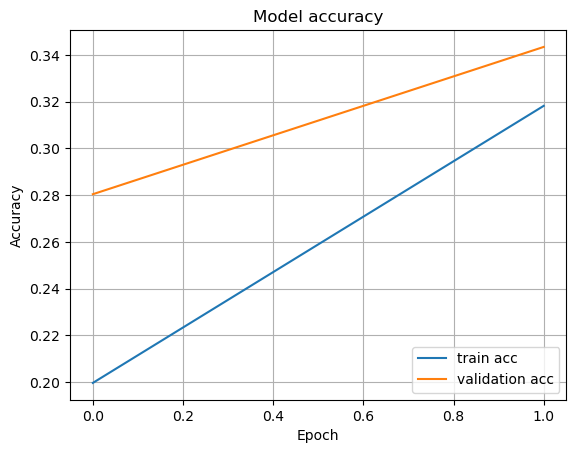

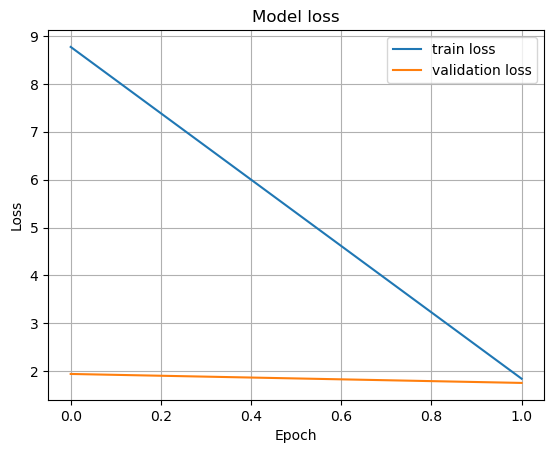

In [13]:
# Accuracyを描画
plt.plot(history['train_acc'])
plt.plot(history['valid_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train acc', 'validation acc'], loc='lower right')
plt.grid(True)
plt.show()

# Lossを描画
plt.plot(history['train_loss'])
plt.plot(history['valid_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.grid(True)
plt.show()

### 重みの保存

In [14]:
# 重みの保存
dir = './'
# torch.save(model.state_dict(), dir + 'ex5_weights.pth')

# 重みの読込
# model = model().to(device)                                    # 保存時と全く同じ構成のモデルを構築
# params = torch.load(dir + 'ex5_weights.pth', map_location=device)   # 保存した重みを読み出す
# model.load_state_dict(params)                                       # 重みをモデルに反映

## 4. モデルの検証(Test)
---

In [15]:
test_loader = DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=False,
    pin_memory=True,
    num_workers=2
)
print(f"test : {len(test_dataset):5.0f} [set]")

test : 10000 [set]


In [16]:
# モデルを評価モードに設定
model.eval()
batch_loss = []
batch_acc = []

# 勾配計算に必要な情報を記録しないよう設定
with torch.no_grad():
    loop = tqdm(test_loader, unit='batch', desc='| Test | Epoch {:>3} |'.format(epoch+1))

    # ミニバッチ単位で繰り返す
    for batch in loop:
        x, label = batch
        x = x.to(device, non_blocking=True)
        label = label.to(device, non_blocking=True)

        # 順伝播のみ行う
        out = model(x)

        # 正答率(accuracy)を算出
        pred_class = torch.argmax(out, dim=1)
        acc = torch.sum(pred_class == label)/len(label)

        # 1バッチ分のaccをリストに保存
        batch_acc.append(acc)

    # バッチ単位の結果を平均し、1エポック分の誤差を算出
    test_avg_loss = torch.tensor(batch_loss).mean()
    test_avg_acc  = torch.tensor(batch_acc).mean()

print("テストデータに対する結果")
print(f"test_loss   ：{test_avg_loss:3.5f}")
print(f"test_acc    ：{test_avg_acc*100:2.3f}%")

| Test | Epoch   2 |: 100%|██████████| 40/40 [00:00<00:00, 53.63batch/s]

テストデータに対する結果
test_loss   ：nan
test_acc    ：35.322%


## おまけ

In [17]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 43 %
Accuracy of   car : 46 %
Accuracy of  bird : 30 %
Accuracy of   cat : 27 %
Accuracy of  deer :  7 %
Accuracy of   dog : 60 %
Accuracy of  frog : 11 %
Accuracy of horse : 33 %
Accuracy of  ship : 42 %
Accuracy of truck : 35 %


In [18]:
!nvidia-smi

Mon Dec 12 19:31:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.46       Driver Version: 526.47       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| 54%   45C    P0   206W / 350W |   6184MiB / 24576MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------